# Mathematical Underpinnings of Machine Learning

## Project C - VaDE

Import modules & set variables

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.io import read_image
from torchvision.datasets import MNIST

from sklearn.mixture import GaussianMixture

In [2]:
sns.set_style('whitegrid')

In [3]:
BATCH_SIZE = 128
IMAGE_SIZE = 28
NUM_CLASSES = 10
TRAIN_EPOCHS = 50
LATENT_DIM = 10
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

## Dataset & dataset loaders - MNIST

In [4]:
class MNISTDataset(Dataset):
    def __init__(self,
                 transform=transforms.Compose([
                    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE), antialias=True),
                    transforms.ToTensor()]),
                 train=True
                ):
        self.dataset = MNIST(root='/tmp', download=True, train=train)
        self.cache = {}
        self.transform = transform
        self.train = train

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img = self.cache.get(idx)
        
        if img is None:
            img, label = self.dataset[idx]
            if self.transform:
                img = self.transform(img)
            img = img.reshape(-1).to(torch.float32)
            
            img = (img, label)
            self.cache[idx] = img
        
        return img

In [6]:
train_dataset = MNISTDataset(train=True)
test_dataset = MNISTDataset(train=False)

In [7]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

train_loader_no_shuffle = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

In [8]:
print(f"There are {len(train_dataset)} train images.")
print(f"There are {len(test_dataset)} test images.")

There are 60000 train images.
There are 10000 test images.


## Models - definitions and training

### Encoder and decoder

In [9]:
def block(dim_in, dim_out):
    return nn.Sequential(
        nn.Linear(dim_in, dim_out),
        nn.ReLU()
    )

In [10]:
class Encoder(nn.Module):
    def __init__(self, input_dim=IMAGE_SIZE**2, hidden_dim=[512, 512, 2048], latent_dim=LATENT_DIM):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim

        dims = hidden_dim.copy()
        dims.insert(0, input_dim)

        self.encoder = nn.Sequential(*[
            block(dims[i], dims[i+1])
            for i in range(len(dims)-1)
        ])

        self.layer_mu = nn.Linear(dims[-1], latent_dim)
        self.layer_log_sigma = nn.Linear(dims[-1], latent_dim)

    def forward(self, x):
        x = self.encoder(x)

        mu = self.layer_mu(x)
        log_sigma = self.layer_log_sigma(x)

        return mu, log_sigma

In [11]:
class Decoder(nn.Module):
    def __init__(self, output_dim=IMAGE_SIZE**2, hidden_dim=[2048, 512, 512], latent_dim=LATENT_DIM):
        super().__init__()
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim

        dims = hidden_dim.copy()
        dims.insert(0, latent_dim)

        self.decoder = nn.Sequential(*[
            block(dims[i], dims[i+1])
            for i in range(len(dims)-1)
        ])

        self.out = nn.Sequential(
            nn.Linear(dims[-1], output_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.decoder(x)
        x = self.out(x)
        return x

### Autoencoders

In [12]:
class AE(nn.Module):
    def __init__(self, encoder, decoder, device='cpu'):
        super().__init__()
        self.device = device
        self.encoder = encoder.to(self.device)
        self.decoder = decoder.to(self.device)
        self.loss_function = nn.MSELoss()
        self.optimizer = Adam(self.parameters())
    
    def fit(self, data_loader, num_epochs=10):  
        loss_list = []
        for _ in tqdm(range(num_epochs)):
            L = 0
            for x, _ in data_loader:
                x = x.to(self.device)
                z, _ = self.encoder(x)
                x_hat = self.decoder(z)
                loss = self.loss_function(x, x_hat)
                L += loss.detach().cpu().numpy()
                
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
            loss_list.append(L / len(data_loader))
                
        self.encoder.layer_log_sigma.load_state_dict(self.encoder.layer_mu.state_dict())
        return loss_list
    
    def forward(self, x):
        z, _ = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat

In [13]:
encoder = Encoder().to(DEVICE)
decoder = Decoder().to(DEVICE)

In [14]:
ae = AE(encoder, decoder, DEVICE)
ae_loss = ae.fit(train_loader, num_epochs=TRAIN_EPOCHS)
torch.save(ae, 'ae.pth')

100%|██████████| 50/50 [05:20<00:00,  6.41s/it]


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


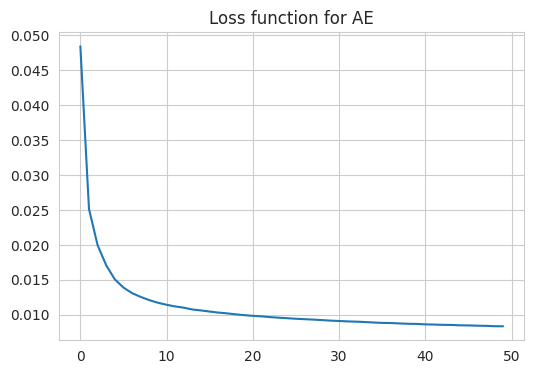

In [15]:
plt.subplots(figsize=(6, 4))
sns.lineplot(x=np.arange(TRAIN_EPOCHS), y=ae_loss)
plt.title('Loss function for AE')
plt.show()

In [16]:
idx = 4000

x = train_dataset[idx][0]
v, _ = ae.encoder.forward(x.to(DEVICE))
x_hat = ae.decoder.forward(v)

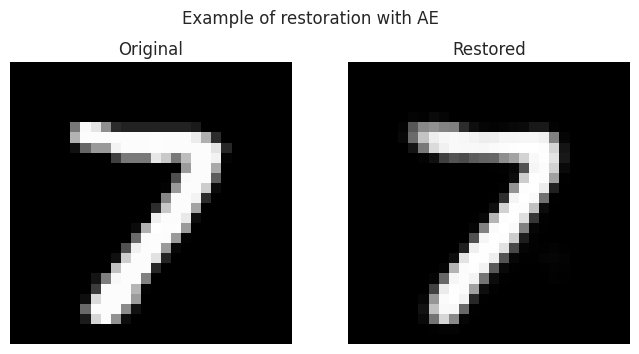

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

plt.sca(ax[0])
plt.imshow(x.reshape(IMAGE_SIZE, IMAGE_SIZE).cpu().detach().numpy(), cmap='gray')
plt.axis('off')
plt.title('Original')

plt.sca(ax[1])
plt.imshow(x_hat.reshape(IMAGE_SIZE, IMAGE_SIZE).cpu().detach().numpy(), cmap='gray')
plt.axis('off')
plt.title('Restored')

plt.suptitle('Example of restoration with AE')
plt.show()

#### VaDE

In [13]:
class VaDE(nn.Module):
    def __init__(self, encoder, decoder, n_clusters, device='cpu'):
        super().__init__()
        self.device = device
        self.encoder = encoder.to(self.device)
        self.decoder = decoder.to(self.device)
        
        self.n_clusters = n_clusters
        self.latent_dim = self.encoder.latent_dim
        
        # set parameters
        self.pi = nn.Parameter((torch.FloatTensor(self.n_clusters).fill_(1) / self.n_clusters).to(self.device), requires_grad=True)
        self.mu = nn.Parameter((torch.FloatTensor(self.n_clusters, self.latent_dim).fill_(0)).to(self.device), requires_grad=True)
        self.log_sigma2 = nn.Parameter((torch.FloatTensor(self.n_clusters, self.latent_dim).fill_(0)).to(self.device), requires_grad=True)
        
        # set initial random data
        pi_ = np.random.uniform(0, 1, self.n_clusters) + 1e-7
        pi_ = pi_ / np.sum(pi_)
        self.pi.data = torch.from_numpy(pi_).to(self.device).float()
        
        mu_ = np.random.normal(0, 1, (self.n_clusters, self.latent_dim))
        self.mu.data = torch.from_numpy(mu_).to(self.device).float()
        
        log_ = np.random.normal(0, 1, (self.n_clusters, self.latent_dim)) ** 2
        self.log_sigma2.data = torch.log(torch.from_numpy(log_).to(self.device).float())

        # the rest
        self.optimizer = Adam(self.parameters())
        self.loss_function = VaDE.VaDE_ELBO_Loss(self.encoder, self.decoder, self.pi, self.mu, self.log_sigma2, self.device)
        
    def fit(self, data_loader, num_epochs=10):
        loss_list = []
        for _ in tqdm(range(num_epochs)):
            L = 0
            for x, _ in data_loader:
                x = x.to(self.device)
                loss = self.loss_function(x)
                L += loss.detach().cpu().numpy()
            
                self.optimizer.zero_grad()
                loss.backward()                
                self.optimizer.step()
            loss_list.append(L / len(data_loader))
        return loss_list
                
    def run_gmm_from_pretrain(self, data_loader):
        Z = []
        with torch.no_grad():
            for x, _ in data_loader:
                x = x.to(self.device)
                z_mu, _ = self.encoder(x)
                Z.append(z_mu)
        
        Z = torch.cat(Z, 0).detach().cpu().numpy()        
        gmm = GaussianMixture(n_components=self.n_clusters, covariance_type='diag').fit(Z)
        
        self.pi.data = torch.from_numpy(gmm.weights_).to(self.device).float()
        self.mu.data = torch.from_numpy(gmm.means_).to(self.device).float()
        self.log_sigma2.data = torch.log(torch.from_numpy(gmm.covariances_).to(self.device).float())
                
    def forward(self, x):
        z_mu, z_sigma2_log = self.encoder(x)
        z = z_mu + torch.randn_like(z_mu) * torch.exp(0.5 * z_sigma2_log)
        x_hat = self.decoder(z)
        return x_hat
    
    def predict_cluster(self, x):
        with torch.no_grad():
            z_mu, z_sigma2_log = self.encoder(x)
            z = z_mu + torch.randn_like(z_mu) * torch.exp(0.5 * z_sigma2_log)

            gamma = torch.exp(
                torch.log(self.pi.unsqueeze(0)) + 
                self.loss_function.log_gaussian_pdf_vector(z, self.mu, self.log_sigma2)
            )
            gamma = gamma / (gamma.sum(1).view(-1,1))
            gamma = gamma.detach().cpu().numpy()
        
        return np.argmax(gamma, axis=1)
    
    def generate(self, cluster=None, return_z=False):
        if cluster is None:
            cluster = np.random.choice(self.n_clusters, 1, p=self.pi.detach().cpu().numpy())[0]
        
        with torch.no_grad():
            mu = self.mu[cluster].detach().cpu().numpy()
            log_sigma2 = self.log_sigma2[cluster].detach().cpu().numpy()
            sigma = np.sqrt(np.exp(log_sigma2))
            z_sample = torch.from_numpy(np.random.multivariate_normal(mu, np.diag(sigma), (1,))).to(self.device)
            res = self.decoder(z_sample.to(torch.float32).to(vade.device)).detach().cpu()
            
        if return_z:
            return res, z_sample.detach().cpu()
        else:
            return res
        
    class VaDE_ELBO_Loss:
        def __init__(self, encoder, decoder, pi, mu, log_sigma2, device):
            self.encoder = encoder
            self.decoder = decoder
            self.pi = pi
            self.mu = mu
            self.log_sigma2 = log_sigma2
            self.device = device
            
            self._pi_value = torch.Tensor((np.pi,)).to(self.device)
        
        def __call__(self, x):
            L = 0
            
            # for simplicity, he number of Monte Carlo samples in the SGVB estimator is 1
            # in Appendix C it was written that it can be set to 1
            z_mu, z_sigma2_log = self.encoder(x)
            z = z_mu + torch.randn_like(z_mu) * torch.exp(0.5 * z_sigma2_log)
            x_hat = self.decoder(z)
            L += F.binary_cross_entropy(x_hat, x, reduction='sum') # sum x_i * mu_x|i
            
            gamma = torch.exp(
                torch.log(self.pi.unsqueeze(0)) + 
                self.log_gaussian_pdf_vector(z, self.mu, self.log_sigma2)
            ) + 1e-10
            gamma = gamma / (gamma.sum(1).view(-1,1))
            
            L += 0.5 * torch.mean(torch.sum(gamma * torch.sum(
                self.log_sigma2.unsqueeze(0) +
                torch.exp(z_sigma2_log.unsqueeze(1) - self.log_sigma2.unsqueeze(0)) + # == division
                (z_mu.unsqueeze(1) - self.mu.unsqueeze(0)).pow(2) / torch.exp(self.log_sigma2.unsqueeze(0)), 
           2), 1))

            L -= (torch.mean(torch.sum(gamma * torch.log(self.pi.unsqueeze(0) / gamma), 1)) + 0.5 * torch.mean(torch.sum(1 + z_sigma2_log, 1)))
            
            return L
            
        def log_gaussian_pdf_single(self, x, mu, log_sigma2):
            # Appendix B
            return -0.5 * (torch.sum(torch.log(self._pi_value*2) + log_sigma2 + (x-mu).pow(2) / torch.exp(log_sigma2), 1))

        def log_gaussian_pdf_vector(self, x, mu, log_sigma2):
            # Appendix B
            G=[]
            for cluster in range(len(mu)):
                G.append(self.log_gaussian_pdf_single(x, mu[cluster:cluster+1,:], log_sigma2[cluster:cluster+1,:]).view(-1,1))
            return torch.cat(G, 1)

**Pre-trained weights**

In [19]:
vade = VaDE(encoder, decoder, NUM_CLASSES, DEVICE)
vade.run_gmm_from_pretrain(train_loader)
vade_loss = vade.fit(train_loader, num_epochs=TRAIN_EPOCHS)
torch.save(vade, 'vade.pth')

100%|██████████| 50/50 [06:33<00:00,  7.87s/it]


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


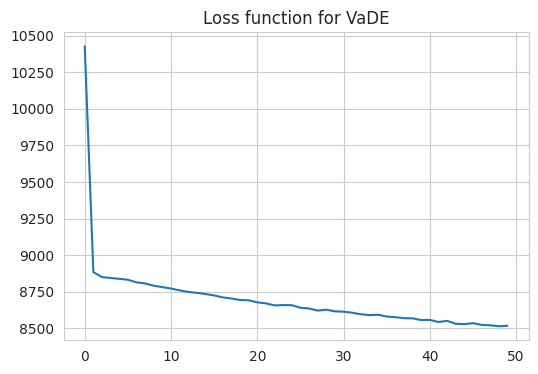

In [20]:
plt.subplots(figsize=(6, 4))
sns.lineplot(x=np.arange(TRAIN_EPOCHS), y=vade_loss)
plt.title('Loss function for VaDE')
plt.show()

In [25]:
cluster = 0
img_generated = vade.generate(cluster)

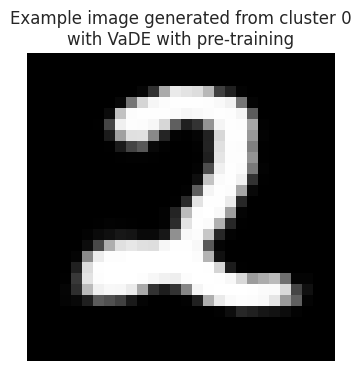

In [26]:
fig, ax = plt.subplots(figsize=(4, 4))
plt.imshow(img_generated.reshape(IMAGE_SIZE, IMAGE_SIZE).cpu().detach().numpy(), cmap='gray')
plt.axis('off')
plt.title(f'Example image generated from cluster {cluster}\nwith VaDE with pre-training')
plt.show()

**Without pre-training**

In [27]:
encoder = Encoder().to(DEVICE)
decoder = Decoder().to(DEVICE)

In [28]:
vade_raw = VaDE(encoder, decoder, NUM_CLASSES, DEVICE)
vade_raw_loss = vade_raw.fit(train_loader, num_epochs=TRAIN_EPOCHS)
torch.save(vade_raw, 'vade_no_pretrain.pth')

100%|██████████| 50/50 [06:30<00:00,  7.82s/it]


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


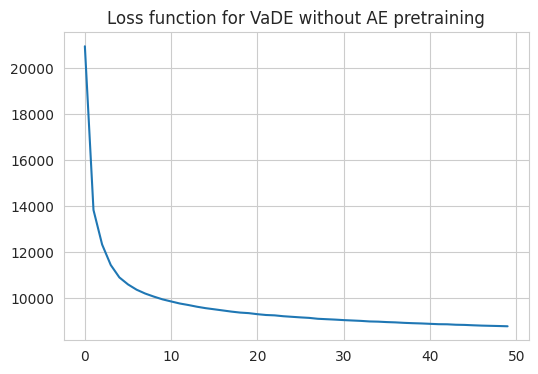

In [29]:
plt.subplots(figsize=(6, 4))
sns.lineplot(x=np.arange(TRAIN_EPOCHS), y=vade_raw_loss)
plt.title('Loss function for VaDE without AE pretraining')
plt.show()

In [32]:
cluster = 0
img_generated = vade_raw.generate(cluster)

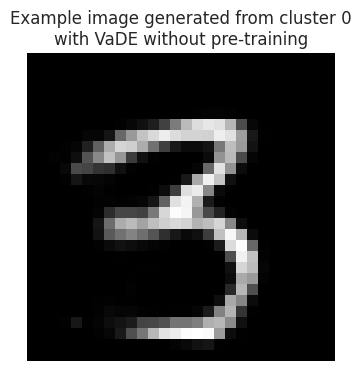

In [33]:
fig, ax = plt.subplots(figsize=(4, 4))
plt.imshow(img_generated.reshape(IMAGE_SIZE, IMAGE_SIZE).cpu().detach().numpy(), cmap='gray')
plt.axis('off')
plt.title(f'Example image generated from cluster {cluster}\nwith VaDE without pre-training')
plt.show()

#### VAE

In [14]:
class VAE(nn.Module):
    def __init__(self, encoder, decoder, device='cpu'):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        self.latent_dim = self.encoder.latent_dim
       
        self.optimizer = Adam(self.parameters())
        self.loss_function = VAE.VAE_ELBO_Loss(self.encoder, self.decoder)
        
    def fit(self, data_loader, num_epochs=10):
        loss_list = []
        for _ in tqdm(range(num_epochs)):
            L = 0
            for x, _ in data_loader:
                x = x.to(self.device)
                loss = self.loss_function(x)
                L += loss.detach().cpu().numpy()
                
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
            loss_list.append(L / len(data_loader))
        return loss_list
                    
    def forward(self, x):
        z_mu, z_sigma2_log = self.encoder(x)
        z = z_mu + torch.randn_like(z_mu) * torch.exp(0.5 * z_sigma2_log)
        x_hat = self.decoder(z)
        return x_hat
    
    def generate(self):       
        with torch.no_grad():
            z_sample = torch.from_numpy(np.random.normal(size=self.latent_dim)).to(self.device).to(torch.float32)
            res = self.decoder(z_sample).detach().cpu()
        return res
        
    class VAE_ELBO_Loss:
        def __init__(self, encoder, decoder):
            self.encoder = encoder
            self.decoder = decoder
        
        def __call__(self, x):
            z_mu, z_sigma2_log = self.encoder(x)
            z = z_mu + torch.randn_like(z_mu) * torch.exp(0.5 * z_sigma2_log)
            x_hat = self.decoder(z)
            
            loss_term = torch.sum(x * torch.log(x_hat + 1e-19) + (1 - x) * torch.log(1 - x_hat + 1e-19))
            KL_term = 0.5 * torch.sum(-z_sigma2_log + torch.exp(z_sigma2_log) + z_mu.pow(2) - 1)
            
            return -torch.mean(loss_term - KL_term)

In [35]:
encoder = Encoder().to(DEVICE)
decoder = Decoder().to(DEVICE)

In [36]:
vae = VAE(encoder, decoder, DEVICE)
vae_loss = vae.fit(train_loader, num_epochs=TRAIN_EPOCHS)
torch.save(vae, 'vae.pth')

100%|██████████| 50/50 [05:29<00:00,  6.58s/it]


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


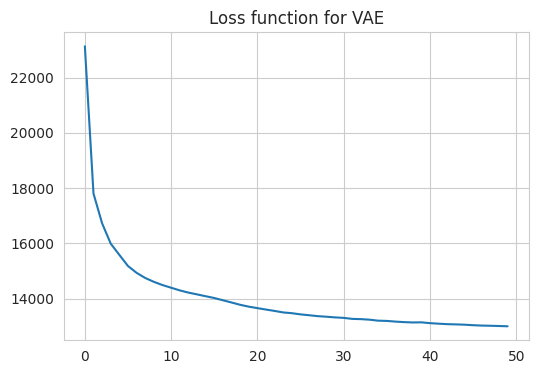

In [37]:
plt.subplots(figsize=(6, 4))
sns.lineplot(x=np.arange(TRAIN_EPOCHS), y=vae_loss)
plt.title('Loss function for VAE')
plt.show()

In [38]:
idx = 4000

x = train_dataset[idx][0]
x_hat = vae.forward(x.to(DEVICE))

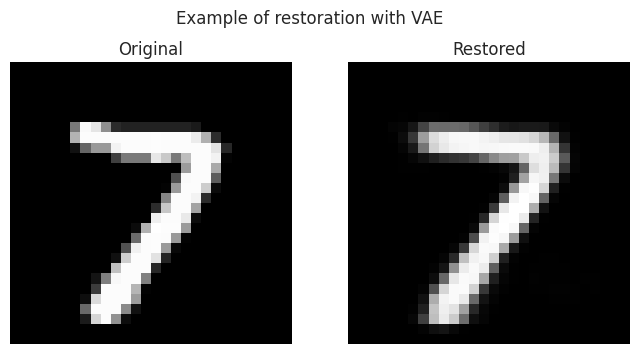

In [39]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

plt.sca(ax[0])
plt.imshow(x.reshape(IMAGE_SIZE, IMAGE_SIZE).cpu().detach().numpy(), cmap='gray')
plt.axis('off')
plt.title('Original')

plt.sca(ax[1])
plt.imshow(x_hat.reshape(IMAGE_SIZE, IMAGE_SIZE).cpu().detach().numpy(), cmap='gray')
plt.axis('off')
plt.title('Restored')

plt.suptitle('Example of restoration with VAE')
plt.show()

## Evaluation

Evaluate the performance of VaDE by comparing the clustering with the true classes. Use at least two metrics.

The following metrics will be used:
* homogeneity score
* completeness score

In [15]:
from sklearn.metrics import homogeneity_score, completeness_score

In [16]:
def preprocess_labels_batch(tab):
    out = []
    for i in range(len(tab)):
        out += list(tab[i])
    return out

In [17]:
def generate_y_true_y_hat(model, loader):
    y_hat = []
    y_true = []
    
    for x, label in loader:
        y_hat.append(model.predict_cluster(x.to(DEVICE)))
        y_true.append(label)
    
    return preprocess_labels_batch(y_true), preprocess_labels_batch(y_hat)

**VaDE with pre-training**

In [43]:
y_true_train, y_hat_train = generate_y_true_y_hat(vade, train_loader)
y_true_test, y_hat_test = generate_y_true_y_hat(vade, test_loader)

In [44]:
print(f"Homogeneity score on train dataset : {homogeneity_score(labels_true=y_true_train, labels_pred=y_hat_train)}")
print(f"Homogeneity score on test dataset  : {homogeneity_score(labels_true=y_true_test, labels_pred=y_hat_test)}")

Homogeneity score on train dataset : 0.6536684290648546
Homogeneity score on test dataset  : 0.6695093138923599


In [45]:
print(f"Completeness score on train dataset : {completeness_score(labels_true=y_true_train, labels_pred=y_hat_train)}")
print(f"Completeness score on test dataset  : {completeness_score(labels_true=y_true_test, labels_pred=y_hat_test)}")

Completeness score on train dataset : 0.6625434639995118
Completeness score on test dataset  : 0.6820942869859302


**VaDE without pre-training**

In [46]:
y_true_train, y_hat_train = generate_y_true_y_hat(vade_raw, train_loader)
y_true_test, y_hat_test = generate_y_true_y_hat(vade_raw, test_loader)

In [47]:
print(f"Homogeneity score on train dataset : {homogeneity_score(labels_true=y_true_train, labels_pred=y_hat_train)}")
print(f"Homogeneity score on test dataset  : {homogeneity_score(labels_true=y_true_test, labels_pred=y_hat_test)}")

Homogeneity score on train dataset : 0.6157279188093022
Homogeneity score on test dataset  : 0.6289812728783482


In [48]:
print(f"Completeness score on train dataset : {completeness_score(labels_true=y_true_train, labels_pred=y_hat_train)}")
print(f"Completeness score on test dataset  : {completeness_score(labels_true=y_true_test, labels_pred=y_hat_test)}")

Completeness score on train dataset : 0.6531919265011956
Completeness score on test dataset  : 0.6697286465958836


## Cluster comparison

Compare clusters identified in the latent space of VaDE with those of VAE (use true classes as clusters) in terms of how well the clusters are defined (for well-defined clusters, observations within the same cluster should be similar, while they should be dissimilar if they are from two different clusters). Use at least two metrics.

The following metrics will be used:
* Silhouette score
* Calinski-Harabasz score

In [18]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score

In [19]:
def observation_to_latent(x, model):
    z_mu, z_sigma2_log = model.encoder.forward(x.to(model.device))
    z = z_mu + torch.randn_like(z_mu) * torch.exp(0.5 * z_sigma2_log)
    return z.detach().cpu().numpy()

In [21]:
y_true_train, y_hat_vade_train = generate_y_true_y_hat(vade, train_loader_no_shuffle)
_, y_hat_vade_no_pretrain_train = generate_y_true_y_hat(vade_raw, train_loader_no_shuffle)

Z_train_vade = np.vstack([
    observation_to_latent(x, vade)
    for x, _ in train_loader_no_shuffle
])

Z_train_vade_no_pretrain = np.vstack([
    observation_to_latent(x, vade_raw)
    for x, _ in train_loader_no_shuffle
])

Z_train_vae = np.vstack([
    observation_to_latent(x, vae)
    for x, _ in train_loader_no_shuffle
])

In [22]:
y_true_test, y_hat_vade_test = generate_y_true_y_hat(vade, test_loader)
_, y_hat_vade_no_pretrain_test = generate_y_true_y_hat(vade_raw, test_loader)

Z_test_vade = np.vstack([
    observation_to_latent(x, vade)
    for x, _ in test_loader
])

Z_test_vade_no_pretrain = np.vstack([
    observation_to_latent(x, vade_raw)
    for x, _ in test_loader
])

Z_test_vae = np.vstack([
    observation_to_latent(x, vae)
    for x, _ in test_loader
])

In [53]:
print(f"Silhouette score on train dataset for VAE                       : {silhouette_score(Z_train_vae, y_true_train)}")
print(f"Silhouette score on train dataset for VaDE with pre-training    : {silhouette_score(Z_train_vade, y_hat_vade_train)}")
print(f"Silhouette score on train dataset for VaDE without pre-training : {silhouette_score(Z_train_vade_no_pretrain, y_hat_vade_no_pretrain_train)}")

Silhouette score on train dataset for VAE                       : 0.03468580171465874
Silhouette score on train dataset for VaDE with pre-training    : 0.12766537070274353
Silhouette score on train dataset for VaDE without pre-training : 0.12976756691932678


In [54]:
print(f"Silhouette score on test dataset for VAE                       : {silhouette_score(Z_test_vae, y_true_test)}")
print(f"Silhouette score on test dataset for VaDE with pre-training    : {silhouette_score(Z_test_vade, y_hat_vade_test)}")
print(f"Silhouette score on test dataset for VaDE without pre-training : {silhouette_score(Z_test_vade_no_pretrain, y_hat_vade_no_pretrain_test)}")

Silhouette score on test dataset for VAE                       : 0.03491850197315216
Silhouette score on test dataset for VaDE with pre-training    : 0.1385515183210373
Silhouette score on test dataset for VaDE without pre-training : 0.1387382596731186


In [55]:
print(f"Calinski-Harabasz score on train dataset for VAE                   : {calinski_harabasz_score(Z_train_vae, y_true_train)}")
print(f"Calinski-Harabasz score on train dataset with pre-training         : {calinski_harabasz_score(Z_train_vade, y_hat_vade_train)}")
print(f"Calinski-Harabasz score on train dataset with without pre-training : {calinski_harabasz_score(Z_train_vade_no_pretrain, y_hat_vade_no_pretrain_train)}")

Calinski-Harabasz score on train dataset for VAE                   : 2149.059401789682
Calinski-Harabasz score on train dataset with pre-training         : 5088.748879517903
Calinski-Harabasz score on train dataset with without pre-training : 4469.185053053997


In [56]:
print(f"Calinski-Harabasz score on test dataset for VAE                    : {calinski_harabasz_score(Z_test_vae, y_true_test)}")
print(f"Calinski-Harabasz score on test dataset with pre-training          : {calinski_harabasz_score(Z_test_vade, y_hat_vade_test)}")
print(f"Calinski-Harabasz score on train dataset with without pre-training : {calinski_harabasz_score(Z_test_vade_no_pretrain, y_hat_vade_no_pretrain_test)}")

Calinski-Harabasz score on test dataset for VAE                    : 366.033512236969
Calinski-Harabasz score on test dataset with pre-training          : 896.1703505741647
Calinski-Harabasz score on train dataset with without pre-training : 799.0183306263859


## Latent space visualisation

Visualise the latent spaces of VaDE and VAE.

The latent spaces will be visualised with TSNE.

In [23]:
from sklearn.manifold import TSNE

In [24]:
tsne_vade = TSNE(n_components=2).fit_transform(Z_test_vade)
tsne_vade_no_pretrain = TSNE(n_components=2).fit_transform(Z_test_vade_no_pretrain)
tsne_vae = TSNE(n_components=2).fit_transform(Z_test_vae)

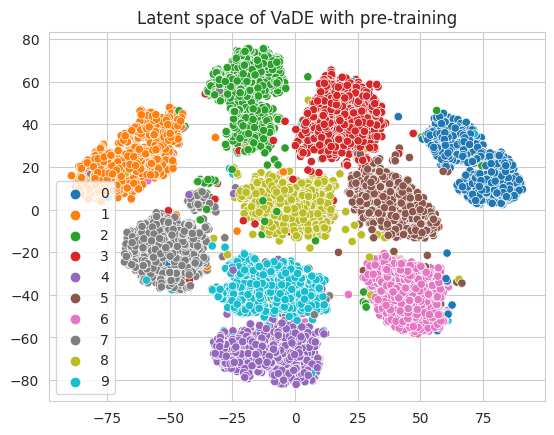

In [25]:
N = 10000
sns.scatterplot(x=tsne_vade[:N, 0], y=tsne_vade[:N, 1], hue=[q.item() for q in y_true_test], palette=sns.color_palette("tab10"))
plt.title('Latent space of VaDE with pre-training')
plt.show()

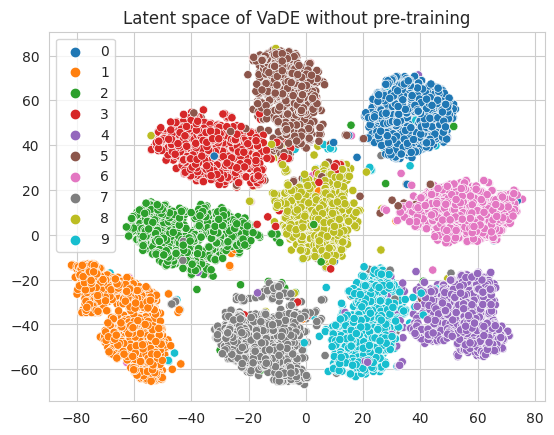

In [26]:
N = 10000
sns.scatterplot(x=tsne_vade_no_pretrain[:N, 0], y=tsne_vade_no_pretrain[:N, 1], hue=[q.item() for q in y_true_test], palette=sns.color_palette("tab10"))
plt.title('Latent space of VaDE without pre-training')
plt.show()

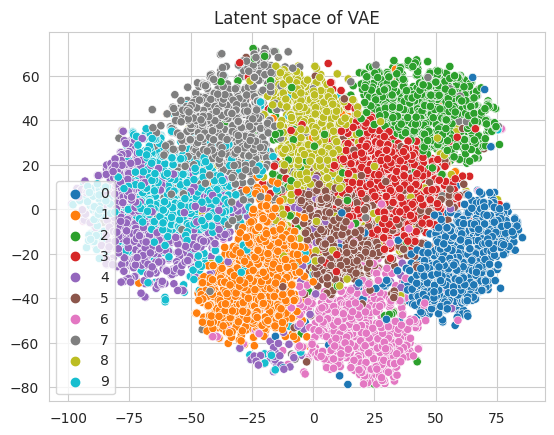

In [27]:
N = 10000
sns.scatterplot(x=tsne_vae[:N, 0], y=tsne_vae[:N, 1], hue=[q.item() for q in y_true_test], palette=sns.color_palette("tab10"))
plt.title('Latent space of VAE')
plt.show()

## New observations

Generate observation from each cluster. Compare the distance of newly generated samples to nearest observations within and out of the clusters, from which they were generated.

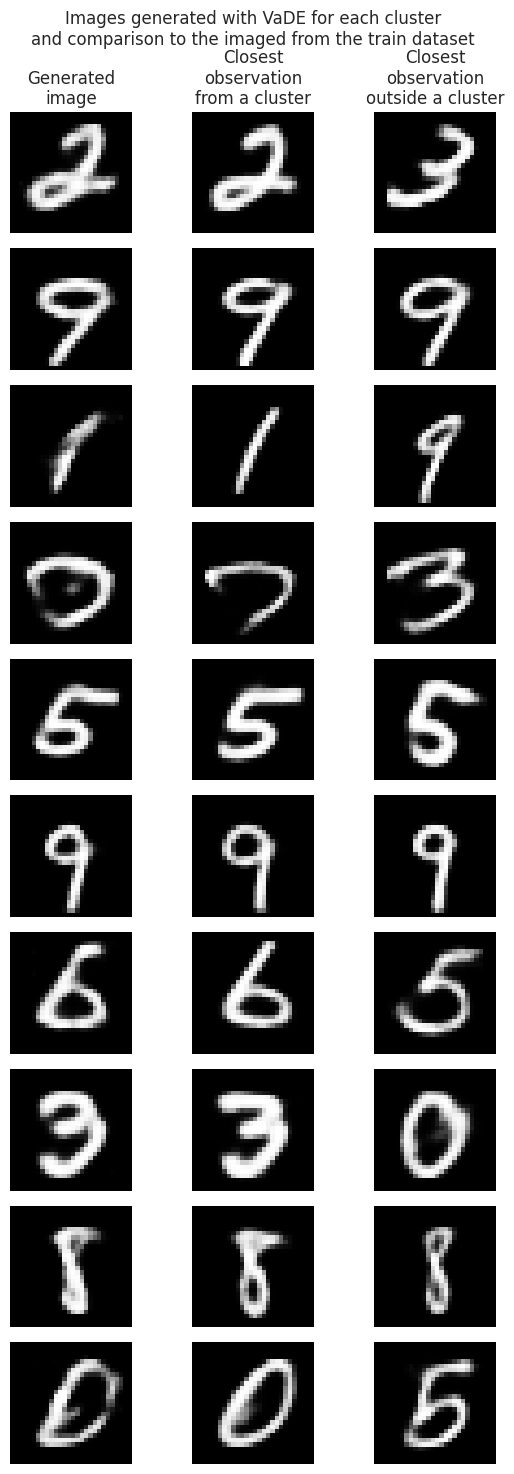

In [88]:
fig, ax = plt.subplots(nrows=10, ncols=3, figsize=(6, 15))

for cluster in range(NUM_CLASSES):   
    # generate image
    img, z = vade.generate(cluster, return_z=True)
    img = img.reshape(IMAGE_SIZE, IMAGE_SIZE).cpu().detach().numpy()
    z = z.cpu().detach().numpy()

    # closest from cluster
    Z_train_from_cluster = Z_train_vade[np.where(np.array(y_hat_vade_train) == cluster)[0], :]
    distances = np.linalg.norm(Z_train_from_cluster - z, axis=1)
    min_index = np.argmin(distances)
    closest_observation_from_cluster = Z_train_from_cluster[min_index]
    img_closest_observation_from_cluster = vade.decoder(torch.from_numpy(closest_observation_from_cluster).to(DEVICE)).reshape(IMAGE_SIZE, IMAGE_SIZE).cpu().detach().numpy()

    # closest outside cluster
    Z_train_outside_cluster = Z_train_vade[np.where(np.array(y_hat_vade_train) != cluster)[0], :]
    distances = np.linalg.norm(Z_train_outside_cluster - z, axis=1)
    min_index = np.argmin(distances)
    closest_observation_outside_cluster = Z_train_outside_cluster[min_index]
    img_closest_observation_outside_clutser = vade.decoder(torch.from_numpy(closest_observation_outside_cluster).to(DEVICE)).reshape(IMAGE_SIZE, IMAGE_SIZE).cpu().detach().numpy()

    # first column
    plt.sca(ax[cluster][0])
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.ylabel(f'Cluster {cluster}')
    
    if cluster == 0:
        plt.title('Generated\nimage')
        
    # second column
    plt.sca(ax[cluster][1])
    plt.imshow(img_closest_observation_from_cluster, cmap='gray')
    plt.axis('off')
    
    if cluster == 0:
        plt.title('Closest\nobservation\nfrom a cluster')
    
    # thirs column
    plt.sca(ax[cluster][2])
    plt.imshow(img_closest_observation_outside_clutser, cmap='gray')
    plt.axis('off')
    
    if cluster == 0:
        plt.title('Closest\nobservation\noutside a cluster')

plt.suptitle('Images generated with VaDE for each cluster\nand comparison to the imaged from the train dataset')
plt.tight_layout()
plt.show()

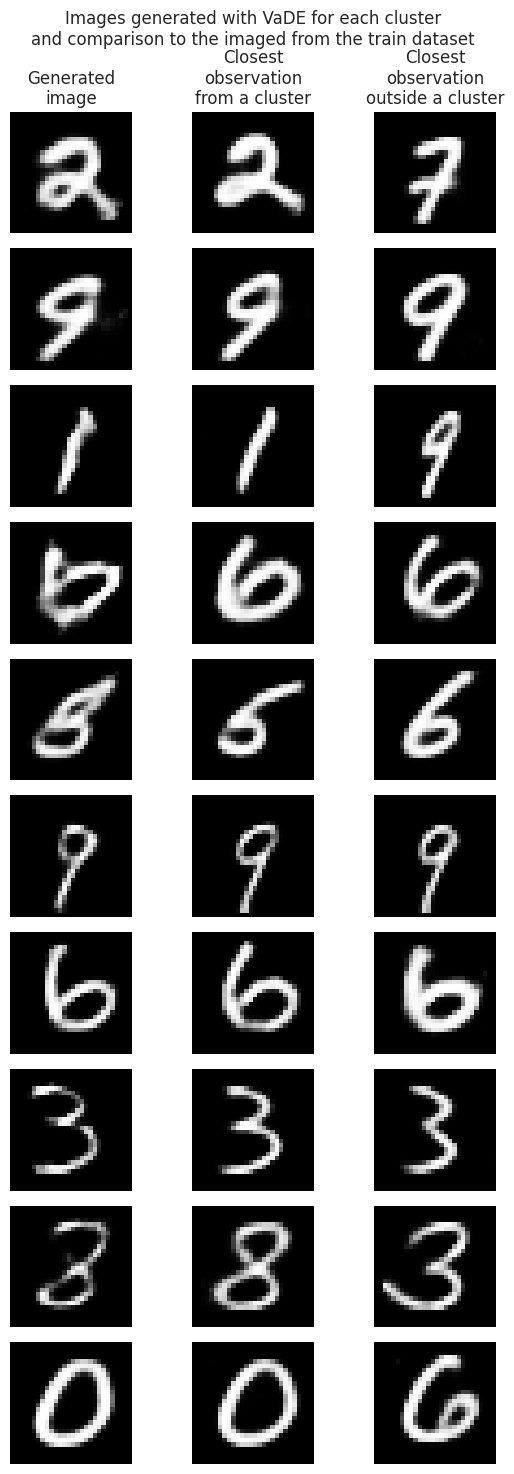

In [92]:
fig, ax = plt.subplots(nrows=10, ncols=3, figsize=(6, 15))

for cluster in range(NUM_CLASSES):   
    # generate image
    img, z = vade.generate(cluster, return_z=True)
    img = img.reshape(IMAGE_SIZE, IMAGE_SIZE).cpu().detach().numpy()
    z = z.cpu().detach().numpy()

    # closest from cluster
    Z_train_from_cluster = Z_train_vade[np.where(np.array(y_hat_vade_train) == cluster)[0], :]
    distances = np.linalg.norm(Z_train_from_cluster - z, axis=1)
    min_index = np.argmin(distances)
    closest_observation_from_cluster = Z_train_from_cluster[min_index]
    img_closest_observation_from_cluster = vade.decoder(torch.from_numpy(closest_observation_from_cluster).to(DEVICE)).reshape(IMAGE_SIZE, IMAGE_SIZE).cpu().detach().numpy()

    # closest outside cluster
    Z_train_outside_cluster = Z_train_vade[np.where(np.array(y_hat_vade_train) != cluster)[0], :]
    distances = np.linalg.norm(Z_train_outside_cluster - z, axis=1)
    min_index = np.argmin(distances)
    closest_observation_outside_cluster = Z_train_outside_cluster[min_index]
    img_closest_observation_outside_clutser = vade.decoder(torch.from_numpy(closest_observation_outside_cluster).to(DEVICE)).reshape(IMAGE_SIZE, IMAGE_SIZE).cpu().detach().numpy()

    # first column
    plt.sca(ax[cluster][0])
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.ylabel(f'Cluster {cluster}')
    
    if cluster == 0:
        plt.title('Generated\nimage')
        
    # second column
    plt.sca(ax[cluster][1])
    plt.imshow(img_closest_observation_from_cluster, cmap='gray')
    plt.axis('off')
    
    if cluster == 0:
        plt.title('Closest\nobservation\nfrom a cluster')
    
    # thirs column
    plt.sca(ax[cluster][2])
    plt.imshow(img_closest_observation_outside_clutser, cmap='gray')
    plt.axis('off')
    
    if cluster == 0:
        plt.title('Closest\nobservation\noutside a cluster')

plt.suptitle('Images generated with VaDE for each cluster\nand comparison to the imaged from the train dataset')
plt.tight_layout()
plt.show()